# 6.6 Time Series Analyis

## This script contains:
1. Importing necessary libraries and data
2. Subsetting, wrangling, and cleaning time-series data
3. Time series analysis: decomposition
4. Testing for stationarity
5. Stationarizing the Data through Differencing

## 01. Importing necessary libraries and data
Because my data set already contains a time variable, i dont need to source additional data from Quandl

In [1]:
# Importing libraries.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear.

In [2]:
# Ensuring that the created graphs stay displayed.

%matplotlib inline

In [3]:
# Setting directory path.
path = r'C:\Users\hachl\Downloads\OpenProject'

In [4]:
# Import project data set.
df = pd.read_csv(os.path.join(path,'DataWHR_Merged.csv'))
df.head()

,Country name,Year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.5,0.718,0.168,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.8,0.679,0.191,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.1,0.600,0.121,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.4,0.496,0.164,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.7,0.531,0.238,0.776,0.614,0.268


In [5]:
df.shape

(2336, 11)

In [6]:
# Rename the columns to simpler syntax

df.rename(columns = {'Country name' : 'country', 'Year': 'year', 'Life Ladder' : 'happiness_rate', 'Log GDP per capita' : 'GDP', 'Social support': 'social_support', 'Healthy life expectancy at birth': 'life_expectancy', 'Freedom to make life choices':'freedom_of_choice', 'Generosity':'charity', 'Perceptions of corruption':'perceived_corruption', 'Positive affect':'positive_emotions', 'Negative affect':'negative_emotions'}, inplace = True)
df.columns

Index(['country', 'year', 'happiness_rate', 'GDP', 'social_support',
       'life_expectancy', 'freedom_of_choice', 'charity',
       'perceived_corruption', 'positive_emotions', 'negative_emotions'],
      dtype='object')

## 02. Subsetting, wrangling, and cleaning time-series data

#### Subsetting: 
the annual data is reported for the years 2005-2023, potentially GDP and individual sentiments were influenced by a global economic recession and a global pandemic. In my analysis so far I haven´t seen a cycle in the plots that could be explained by these historical events. Each individual entry could be explained by a national crisis, for that reason I am keeping the data as it is, except for 2023. In January of this year, the Happiness Report was published with estimated GDPs as the real numbers were not yet public. We can consider this a forecasted variable, therefore 2023 will be omitted from our time-series analysis. Luckily I already have the original data set before merge which does not contain this year´s report.

In [7]:
# Importing second data set

df_2 = pd.read_csv(os.path.join(path, 'DataWHRYears_clean.csv'))
df_2.head()

,Country name,Year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.5,0.718,0.168,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.8,0.679,0.191,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.1,0.600,0.121,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.4,0.496,0.164,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.7,0.531,0.238,0.776,0.614,0.268


In [8]:
df_2.shape

(2199, 11)

In [9]:
# Let´s rename the column again for easier handling

df_2.rename(columns = {'Country name' : 'country', 'Year': 'year', 'Life Ladder' : 'happiness_rate', 'Log GDP per capita' : 'GDP', 'Social support': 'social_support', 'Healthy life expectancy at birth': 'life_expectancy', 'Freedom to make life choices':'freedom_of_choice', 'Generosity':'charity', 'Perceptions of corruption':'perceived_corruption', 'Positive affect':'positive_emotions', 'Negative affect':'negative_emotions'}, inplace = True)
df_2.columns

Index(['country', 'year', 'happiness_rate', 'GDP', 'social_support',
       'life_expectancy', 'freedom_of_choice', 'charity',
       'perceived_corruption', 'positive_emotions', 'negative_emotions'],
      dtype='object')

#### Data consistency check

In [10]:
# Checking for missing values (there shouldn't be any)

df_2.isnull().sum() 

country                 0
year                    0
happiness_rate          0
GDP                     0
social_support          0
life_expectancy         0
freedom_of_choice       0
charity                 0
perceived_corruption    0
positive_emotions       0
negative_emotions       0
dtype: int64

In [11]:
# Checking for duplicates

dups = df_2.duplicated()
dups.sum()

# All rows are unique!

0

#### Create a line chart of the data
I tried to plot 'year' and 'happiness_rate' but it resulted first in 2 single flat lines then in a confusing zig zag. I tried then to solve by grouping values by category 'country' but it kept giving me errors. For this reason, I went to the source and created a new dataset of column averages by year.

In [12]:
# Importing cleaned dataset of same variables in average by year

df_mean = pd.read_csv(os.path.join(path,'WHR_Averages.csv'))
df_mean.head()

,Year,Average of happiness_rate,Average of GDP,Average of social_support,Average of life_expectancy,Average of freedom_of_choice,Average of charity,Average of perceived_corruption,Average of positive_emotions,Average of negative_emotions
0,2005.0,6.446259,10.124222,0.897407,66.825926,0.823481,0.009185,0.718037,0.671222,0.256333
1,2006.0,5.196899,9.068978,0.835809,60.133191,0.731067,0.002067,0.755022,0.660708,0.254798
2,2007.0,5.418275,9.192039,0.807814,61.579716,0.687931,0.009510,0.790284,0.652284,0.250216
3,2008.0,5.418509,9.180427,0.784391,61.190391,0.689982,0.017400,0.763600,0.652845,0.243545
4,2009.0,5.457667,9.274912,0.818991,62.535035,0.688465,-0.008991,0.762904,0.643491,0.247193


In [13]:
df_mean.isnull().sum() 

Year                               1
Average of happiness_rate          1
Average of GDP                     1
Average of social_support          1
Average of life_expectancy         1
Average of freedom_of_choice       1
Average of charity                 1
Average of perceived_corruption    1
Average of positive_emotions       1
Average of negative_emotions       1
dtype: int64

In [14]:
# There seem to be an empty row for each column, even though i cannot find it on the file itself. 
#I will replce this with previous value for now.

df_ffill = df_mean.fillna(method='ffill')

print("\nDataFrame after forward filling NaN values:")
print(df_ffill)


DataFrame after forward filling NaN values:
      Year  Average of happiness_rate  Average of GDP  \
0   2005.0                   6.446259       10.124222   
1   2006.0                   5.196899        9.068978   
2   2007.0                   5.418275        9.192039   
3   2008.0                   5.418509        9.180427   
4   2009.0                   5.457667        9.274912   
5   2010.0                   5.496806        9.406177   
6   2011.0                   5.424082        9.305466   
7   2012.0                   5.443617        9.409915   
8   2013.0                   5.393294        9.384713   
9   2014.0                   5.386264        9.367667   
10  2015.0                   5.400944        9.391641   
11  2016.0                   5.396447        9.389851   
12  2017.0                   5.460408        9.389578   
13  2018.0                   5.498674        9.390922   
14  2019.0                   5.570965        9.453196   
15  2020.0                   5.727517      

In [15]:
df_ffill.isnull().sum() #now it´s clean

Year                               0
Average of happiness_rate          0
Average of GDP                     0
Average of social_support          0
Average of life_expectancy         0
Average of freedom_of_choice       0
Average of charity                 0
Average of perceived_corruption    0
Average of positive_emotions       0
Average of negative_emotions       0
dtype: int64

In [16]:
# Check for duplicates, we should have 1

dupl = df_ffill.duplicated()
dupl.sum() 

1

In [17]:
# Remove duplicate

df_clean = df_ffill.drop_duplicates()

In [18]:
# Check for duplicates, there should be none

dup = df_clean.duplicated()
dup.sum() 

0

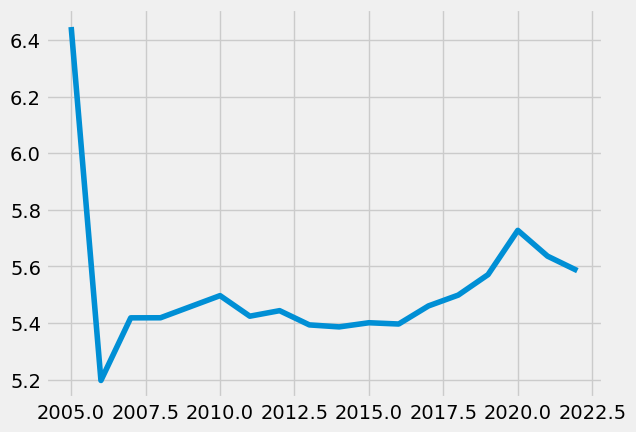

In [19]:
# Correct data for a simple line
x = df_clean['Year']
y = df_clean['Average of happiness_rate']

# Create a line chart
plt.plot(x, y)

# Display the chart
plt.show()

## 03. Time-series analysis: decomposition

In [20]:
# Decompose the time series using an additive model
# Due to several errors, we set index parameters and reread the data

df_clean = pd.read_csv((os.path.join(path,'WHR_Averages.csv')), index_col='Year', parse_dates=True)

In [21]:
# Cleaning again the data set

df_clean.isnull().sum() 

Average of happiness_rate          1
Average of GDP                     1
Average of social_support          1
Average of life_expectancy         1
Average of freedom_of_choice       1
Average of charity                 1
Average of perceived_corruption    1
Average of positive_emotions       1
Average of negative_emotions       1
dtype: int64

In [22]:
# Checking output

df_clean.head()

,Average of happiness_rate,Average of GDP,Average of social_support,Average of life_expectancy,Average of freedom_of_choice,Average of charity,Average of perceived_corruption,Average of positive_emotions,Average of negative_emotions
Year,,,,,,,,,
2005-01-01,6.446259,10.124222,0.897407,66.825926,0.823481,0.009185,0.718037,0.671222,0.256333
2006-01-01,5.196899,9.068978,0.835809,60.133191,0.731067,0.002067,0.755022,0.660708,0.254798
2007-01-01,5.418275,9.192039,0.807814,61.579716,0.687931,0.009510,0.790284,0.652284,0.250216
2008-01-01,5.418509,9.180427,0.784391,61.190391,0.689982,0.017400,0.763600,0.652845,0.243545
2009-01-01,5.457667,9.274912,0.818991,62.535035,0.688465,-0.008991,0.762904,0.643491,0.247193


In [23]:
# Removing missing values

df_clean_2 = df_clean.dropna()

In [24]:
df_clean_2.isnull().sum() # no blank entries found!

Average of happiness_rate          0
Average of GDP                     0
Average of social_support          0
Average of life_expectancy         0
Average of freedom_of_choice       0
Average of charity                 0
Average of perceived_corruption    0
Average of positive_emotions       0
Average of negative_emotions       0
dtype: int64

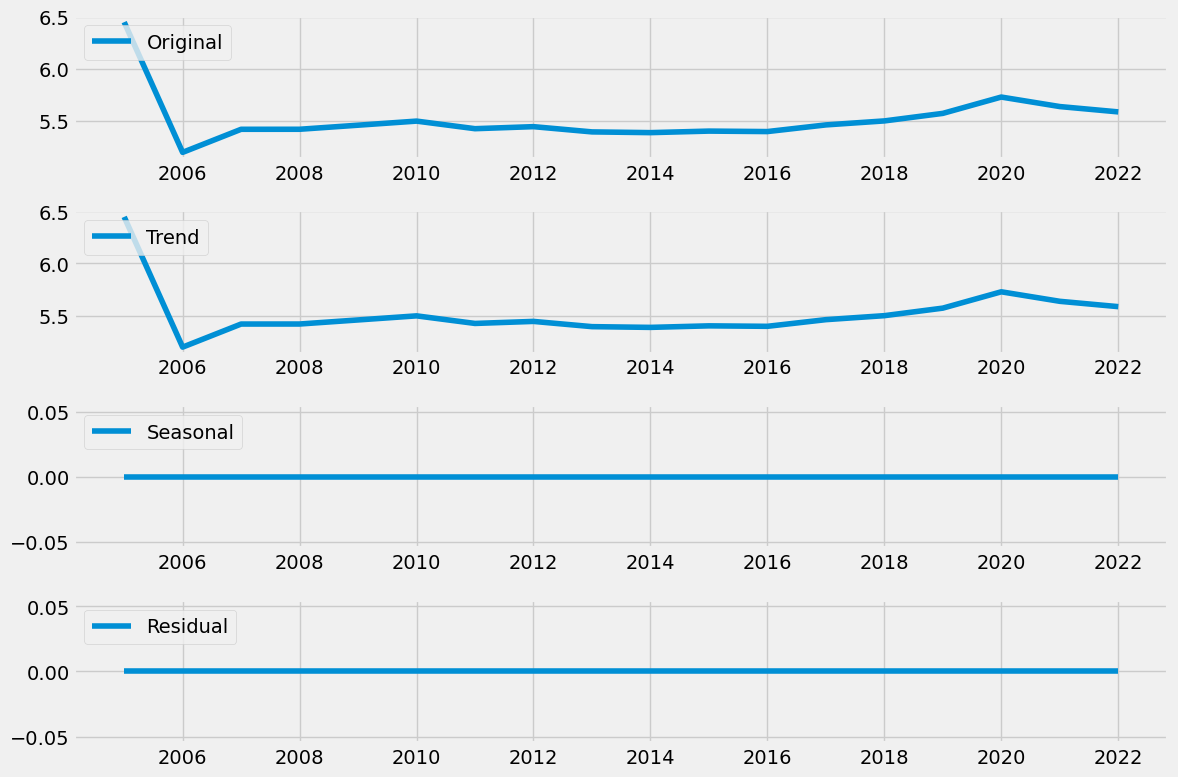

In [34]:
# Try decomposing the time series again using an additive model
# Assuming df_clean_2 is a DataFrame with a 'Year' index and a column 'value'
# df_clean_2 = pd.read_csv('your_data.csv', parse_dates=['Year'], index_col='Year')

# Perform seasonal decomposition with an annual period (assuming yearly data)
decomposition = sm.tsa.seasonal_decompose(df_clean_2['Average of happiness_rate'], model='additive', period=1)

# Plot the decomposed components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(df_clean_2['Average of happiness_rate'], label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [35]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

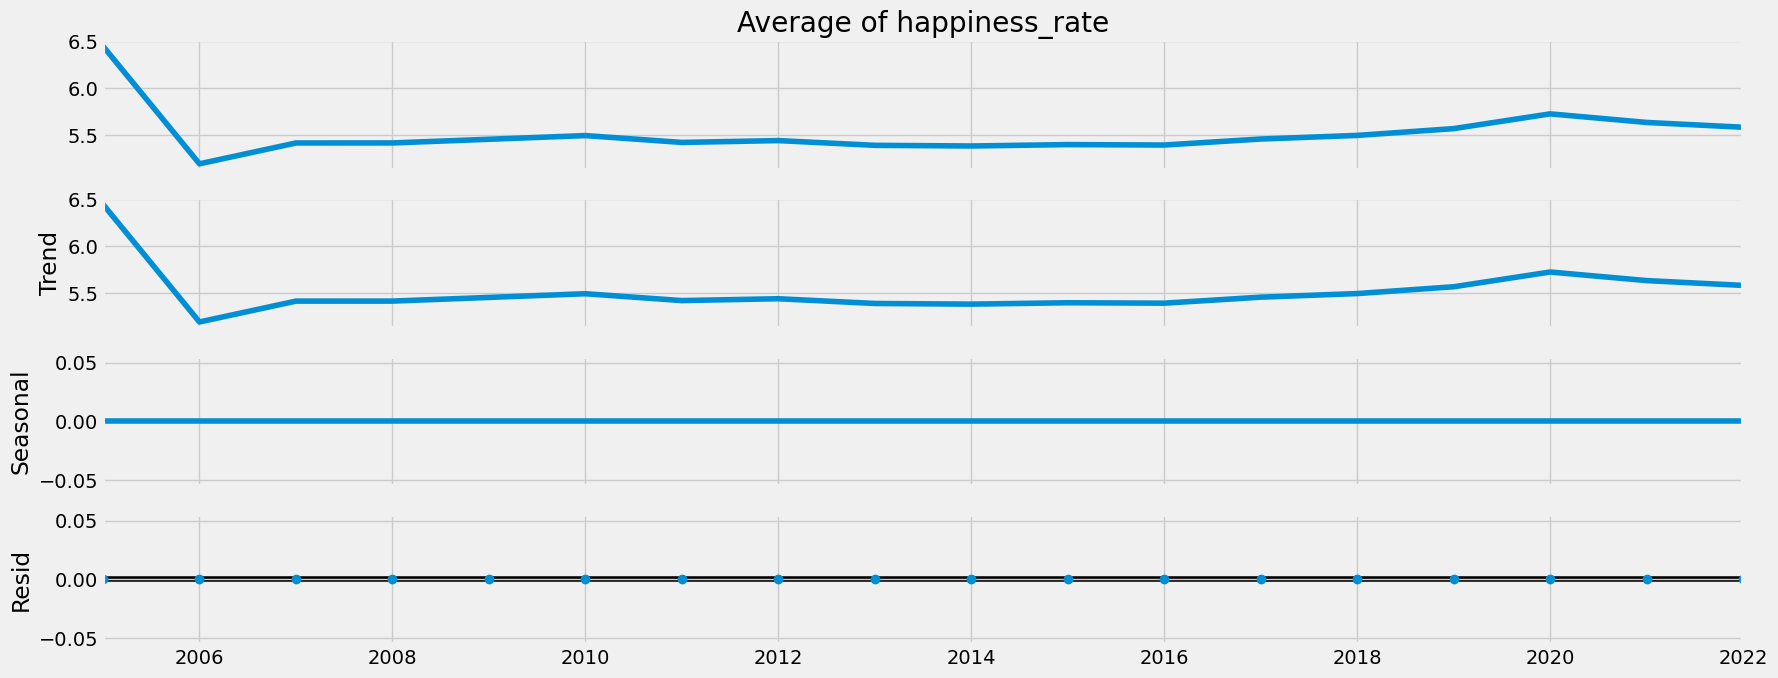

In [36]:
# Plot the separate components

decomposition.plot()
plt.show()

#### Insights: 
In our decomposition plot the original and trend lines are the same, and the seasonal and residual components are flat lines, indicating that the time series data does not exhibit a clear pattern.

- When the trend is a flat line and is the same as the original line, it suggests that the data doesn't exhibit a consistent upward or downward movement.
- When the seasonal component is a flat line, it indicates that there is no consistent seasonal pattern in the data.
- When the residual is a flat line, it suggests that there is no significant unexplained variability in the data.

In conclusion, these lines imply a relatively stable time series without a clear trend, seasonality, or residual patterns (possible stationary data, where the mean and variance remain constant over time).

## 04. Testing for stationarity

In [38]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_clean_2['Average of happiness_rate'])

Dickey-Fuller Stationarity test:
Test Statistic                 -0.778959
p-value                         0.825225
Number of Lags Used             7.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64


#### Insights on theDickey-Fuller stationarity test results: If you can’t rule out the null hypothesis, your data is non-stationary.

- Null hypothesis = time series is non-stationary
- If Test statistic larger than critical value = can’t reject null hypothesis
- If Test statistic smaller than critical value = can reject null hypothesis

- The test statistic is -0.778959 and Critical Value (5%) is -3.232950: Test statistics is much bigger than Critical value, which means that we can’t reject the null hypothesis and that our time series likely exhibits some form of trend.

## 05. Stationarizing the Data through Differencing

In [39]:
data_diff = df_clean_2 - df_clean_2.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [40]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [41]:
data_diff.head()

,Average of happiness_rate,Average of GDP,Average of social_support,Average of life_expectancy,Average of freedom_of_choice,Average of charity,Average of perceived_corruption,Average of positive_emotions,Average of negative_emotions
Year,,,,,,,,,
2006-01-01,-1.249360,-1.055245,-0.061598,-6.692735,-0.092414,-0.007118,0.036985,-0.010514,-0.001536
2007-01-01,0.221376,0.123062,-0.027995,1.446525,-0.043136,0.007442,0.035262,-0.008424,-0.004582
2008-01-01,0.000235,-0.011612,-0.023423,-0.389325,0.002050,0.007890,-0.026684,0.000561,-0.006670
2009-01-01,0.039158,0.094485,0.034600,1.344644,-0.001517,-0.026391,-0.000696,-0.009354,0.003648
2010-01-01,0.039140,0.131265,0.012170,0.386191,0.020438,0.008338,-0.006162,0.003412,-0.005540


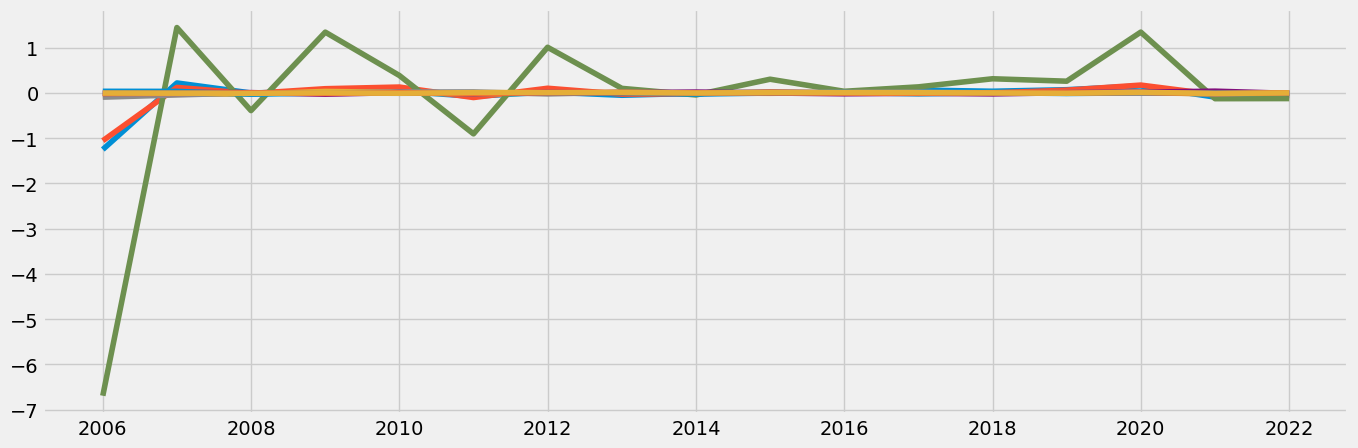

In [42]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [45]:
# Select the specific column for testing

data_diff = data_diff['Average of happiness_rate']  

# Perform the Dickey-Fuller test
result = adfuller(data_diff)

# Display the results
print("Test Statistic:", result[0])
print("p-value:", result[1])
print("Number of Lags Used:", result[2])
print("Number of Observations Used:", result[3])
print("Critical Values:", result[4])

Test Statistic: -1.6365433503551963
p-value: 0.4640675577259019
Number of Lags Used: 5
Number of Observations Used: 11
Critical Values: {'1%': -4.223238279489106, '5%': -3.189368925619835, '10%': -2.729839421487603}


##### The test statistic is -1.6365 and Critical Value (5%) is -3.18937: Test statistics is still bigger than Critical value, which means that we can’t reject the null hypothesis of non-stationarity.

In [47]:
# Apply differencing again
data_diff_2 = data_diff - data_diff.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [51]:
data_diff_2.dropna(inplace = True)

In [53]:
data_diff_2.head()

Year
2007-01-01    1.470736
2008-01-01   -0.221141
2009-01-01    0.038923
2010-01-01   -0.000018
2011-01-01   -0.111864
Name: Average of happiness_rate, dtype: float64

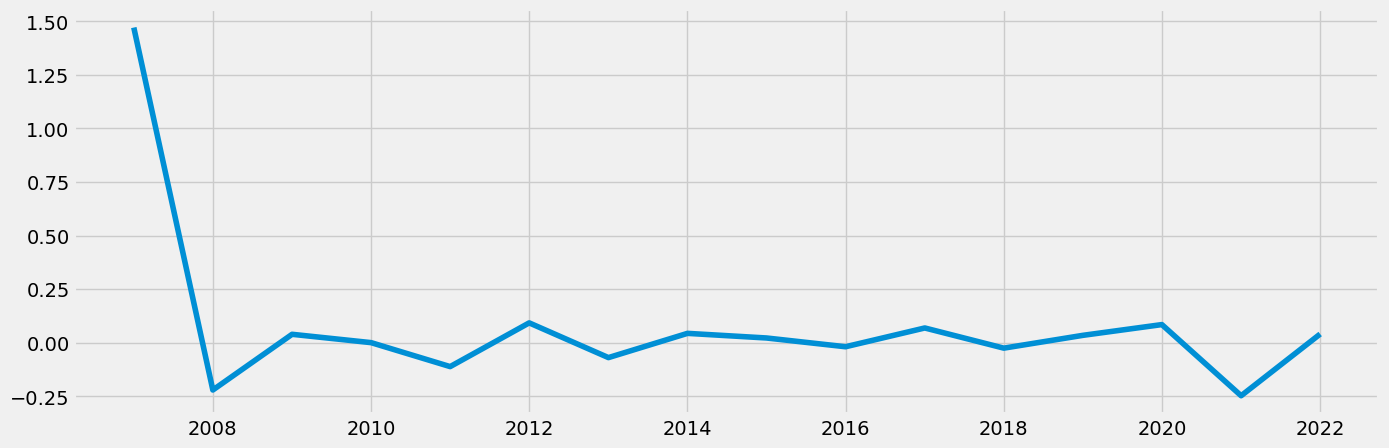

In [54]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_2)

In [55]:
# Test stationarity once more
dickey_fuller(data_diff_2)

Dickey-Fuller Stationarity test:
Test Statistic                 -1.063698
p-value                         0.729330
Number of Lags Used             5.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64


##### Test Statistic (-1.063698) is still bigger than Critical values (5% at -3.232950), null hypothesis cannot be rejected.
We should explore other methods to stationarise our data, otherwise it cannot be used for forecasting.

In [57]:
# Apply log transformation to the entire DataFrame
data_diff_2_log = np.log(data_diff_2)

# Display the transformed data
print("Original DataFrame:")
print(data_diff_2)

print("\nDataFrame after Log Transformation:")
print(data_diff_2_log)

Original DataFrame:
Year
2007-01-01    1.470736
2008-01-01   -0.221141
2009-01-01    0.038923
2010-01-01   -0.000018
2011-01-01   -0.111864
2012-01-01    0.092259
2013-01-01   -0.069858
2014-01-01    0.043293
2015-01-01    0.021710
2016-01-01   -0.019177
2017-01-01    0.068458
2018-01-01   -0.025696
2019-01-01    0.034026
2020-01-01    0.084261
2021-01-01   -0.247824
2022-01-01    0.040166
Name: Average of happiness_rate, dtype: float64

DataFrame after Log Transformation:
Year
2007-01-01    0.385763
2008-01-01         NaN
2009-01-01   -3.246170
2010-01-01         NaN
2011-01-01         NaN
2012-01-01   -2.383154
2013-01-01         NaN
2014-01-01   -3.139772
2015-01-01   -3.829982
2016-01-01         NaN
2017-01-01   -2.681532
2018-01-01         NaN
2019-01-01   -3.380640
2020-01-01   -2.473837
2021-01-01         NaN
2022-01-01   -3.214740
Name: Average of happiness_rate, dtype: float64


In [62]:
# Drop NaN created with Log Transformation
data_diff_2_log.dropna(inplace = True)

In [63]:
# Test stationarity one last time
dickey_fuller(data_diff_2_log)

Dickey-Fuller Stationarity test:
Test Statistic                -7.728963e+00
p-value                        1.138873e-11
Number of Lags Used            0.000000e+00
Number of Observations Used    8.000000e+00
Critical Value (1%)           -4.665186e+00
Critical Value (5%)           -3.367187e+00
Critical Value (10%)          -2.802961e+00
dtype: float64


#### Our data is now stationary!

Null hypothesis can be rejected as Test statistic(-7.72896) is smaller than Critical values (5% at -3.36719),  which means that our time series shows no patterns or trends.

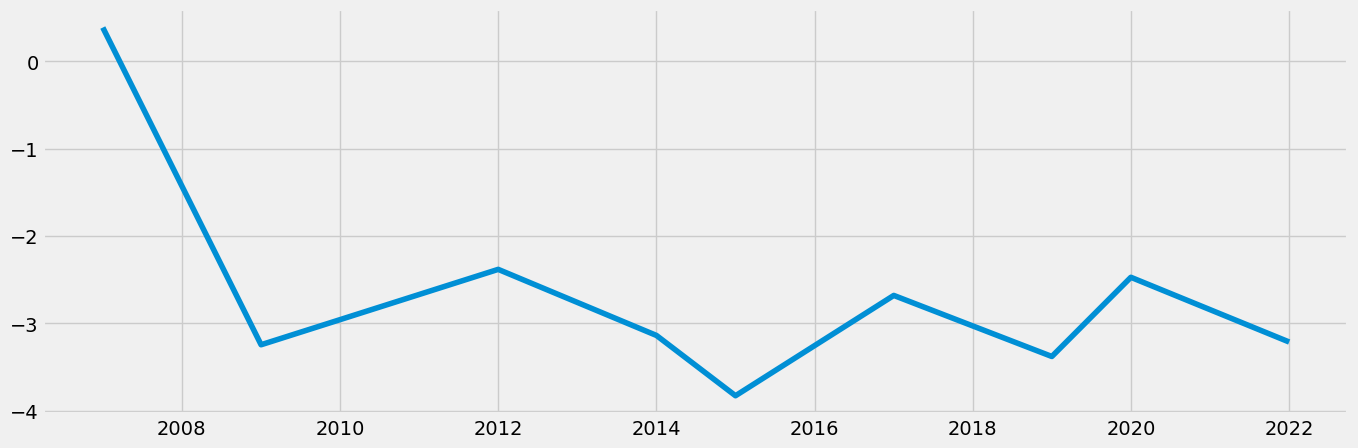

In [65]:
# Check out what the log transforming did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_2_log)

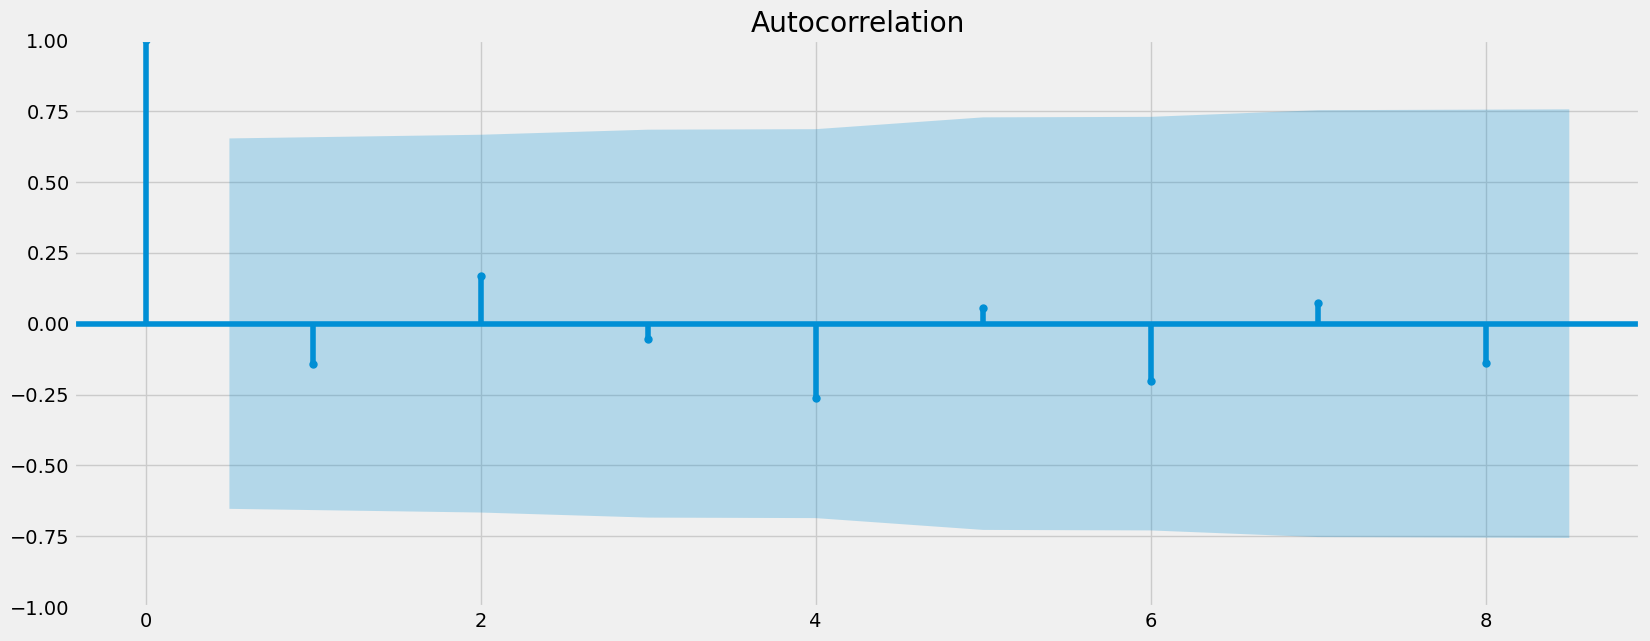

In [66]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_diff_2_log)
plt.show()

##### Insights on autocorrelations test
Autocorrelation shows whether there is a relationship between the values of a variable at different points in time, by calculating their correlation coefficients:

- a positive coefficient suggests a positive relationship between current and past values (blue line over 0). When there are many lags beyond zero, you can deduce that the data is non-stationary (in this case i count 4 lags of different coefficents)

- a negative coefficient suggests a negative relationship (blue line under 0)

- a coefficient value near zero suggests little to no correlation.

It seems that we don´t have stationary data after all.